# Dog Breed I: Keras - VGG16 

## Introduction

I am following the fast.ai course, and this is my take on the Dog Breed competition based on that. In this an other notebooks I will try to get a good score on the Dog Breed competition (say top 50%).

As a starting point, I will fine-tune the VGG16 model, for this, following the example of the dogs vs cat competition of the course. I already have saved the data as suggested. In the data folder I have train, validation and test folders.

In this notebook I will:

* Define the VGG-16 model using Keras, load the weights, and fine-tune it for this competition
* Train the fine-tune version of the model
* Produce a submission file for Kaggle

But first let's us load some libraries

In [1]:
%matplotlib inline

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import FileLink


import keras.backend as K
from keras.layers import Dense, Flatten, Lambda, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image

Using TensorFlow backend.
/home/benjamin/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


And this is to avoid too many OOM:

In [2]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [3]:
limit_mem()

## VGG-model

This part is just the VGG model definition. I have downloaded the weights for this previously, which I found at
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [4]:
initial_weights_path = 'models/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

In [5]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
def preproc(x):
    x = x - vgg_mean
    return x[:,:,:,::-1]

def conv_block(model, layers, filters):
    for i in range(layers):
        model.add(Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

def fc_block(model, do):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(do))

def vgg16(do):
    model = Sequential()
    
    model.add(Lambda(preproc, input_shape=(224,224,3)))
    
    conv_block(model, 2, 64)
    conv_block(model, 2, 128)
    conv_block(model, 3, 256)
    conv_block(model, 3, 512)
    conv_block(model, 3, 512)
    
    model.add(Flatten())
    fc_block(model, do)
    fc_block(model, do)
    model.add(Dense(1000, activation='softmax'))
    
    return model

In [6]:
model = vgg16(0)

In [8]:
model.load_weights(initial_weights_path)

Now that we have the model with the weights loaded, we can fine tune it. Recall that for Dog Breed competition there are 120 categories so:

In [9]:
model.pop()
for layer in model.layers: layer.trainable=False

In [10]:
model.add(Dense(120, activation='softmax'))

## Train the model

Now, we prepare the batches and train the model. In the first run, to verify that everything works, I will use the sample path, then I will subtitute it with the real path:

In [11]:
#path = 'data/sample/'
path = 'data/'

In [12]:
batch_size = 64

In [13]:
def get_batch(path, gen=image.ImageDataGenerator(), batch_size=4, shuffle=False):
    return gen.flow_from_directory(path, target_size=(224,224), batch_size=batch_size, shuffle=shuffle)

In [14]:
train_batch = get_batch(path + 'train', batch_size=batch_size, shuffle=True)
valid_batch = get_batch(path + 'valid', batch_size=batch_size)
steps_per_epoch = int(train_batch.n/batch_size)
validation_steps = int(valid_batch.n/batch_size)

Found 9254 images belonging to 120 classes.
Found 968 images belonging to 120 classes.


In [15]:
model.compile(Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit_generator(train_batch,steps_per_epoch, epochs=1,
                   validation_data=valid_batch, validation_steps=validation_steps)

Epoch 1/1
145/144 [==============================] - 543s 4s/step - loss: 3.1109 - acc: 0.3154 - val_loss: 1.5570 - val_acc: 0.5630


In [17]:
model.fit_generator(train_batch,steps_per_epoch, epochs=4,
                   validation_data=valid_batch, validation_steps=validation_steps)

Epoch 1/4
145/144 [==============================] - 46s 316ms/step - loss: 1.1649 - acc: 0.6643 - val_loss: 1.1470 - val_acc: 0.6622
Epoch 2/4
145/144 [==============================] - 46s 316ms/step - loss: 0.8121 - acc: 0.7593 - val_loss: 1.0115 - val_acc: 0.6880
Epoch 3/4
145/144 [==============================] - 46s 320ms/step - loss: 0.6223 - acc: 0.8187 - val_loss: 0.9510 - val_acc: 0.7128
Epoch 4/4
145/144 [==============================] - 46s 315ms/step - loss: 0.4944 - acc: 0.8613 - val_loss: 0.9150 - val_acc: 0.7149


Right now it is overfitting but still improving. I am going to use this as my starting point.

## Create a submission file

Now, to obtain the predictions is easy, but they are not real probabilities of each category, since the model, as far as I understand, tends to be overconfident. Which means we have to adjust the result for that. I designed the following function which tries to accomplish this:

In [18]:
def adj(prediction, top_sum=0.98):
    low_bar = 1-top_sum
    adj_pred = np.copy(prediction)
    old_top_sum = np.sum(adj_pred[adj_pred>=low_bar])
    # We scale all the probabilities which are in a nice range, to add up to top_sum
    adj_pred[adj_pred>=low_bar] = (top_sum/old_top_sum)*adj_pred[adj_pred>=low_bar] 
    # And set the rest so that they add up to low_bar.
    adj_pred[adj_pred < low_bar] = low_bar/np.sum(adj_pred < low_bar)
    return adj_pred

In [19]:
test_path = path + 'test/'

In [20]:
dic_classes = valid_batch.class_indices
inv_dic = {str(v): k for k,v in dic_classes.items()}

In [23]:
len(glob.glob(test_path + 'unknown/*'))

10357

In [25]:
test_batches = get_batch(test_path, batch_size=batch_size, shuffle=False)
test_steps = int(test_batches.n/batch_size)
names_of_pics = sorted(os.listdir(test_path+'unknown'))

Found 10357 images belonging to 1 classes.


In [26]:
predictions = model.predict_generator(test_batches, steps=test_steps)

In [27]:
predictions.shape

(10357, 120)

In [29]:
test_df = pd.DataFrame()
test_df['id'] = [name[:-4] for name in names_of_pics]
test_df.set_index('id', inplace=True)

In [30]:
test_df

""
id
000621fb3cbb32d8935728e48679680e
00102ee9d8eb90812350685311fe5890
0012a730dfa437f5f3613fb75efcd4ce
001510bc8570bbeee98c8d80c8a95ec1
001a5f3114548acdefa3d4da05474c2e
00225dcd3e4d2410dd53239f95c0352f
002c2a3117c2193b4d26400ce431eebd
002c58d413a521ae8d1a5daeb35fc803
002f80396f1e3db687c5932d7978b196


Let's check that the images are in the right order:

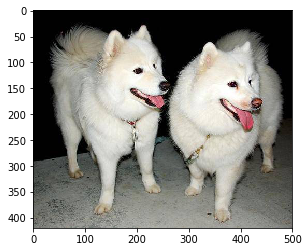

In [35]:
plt.imshow(image.load_img(test_path + 'unknown/' + names_of_pics[1]))

In [33]:
imgs, _ = next(test_batches)

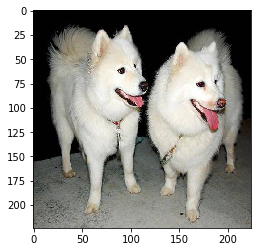

In [36]:
plt.imshow(image.array_to_img(imgs[1]))

In [39]:
probs = np.array([adj(pred) for pred in predictions])

In [40]:
for i in range(len(inv_dic)):
    test_df[inv_dic[str(i)]] = np.transpose(probs)[i]

In [41]:
test_df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,...,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168
00102ee9d8eb90812350685311fe5890,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,...,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171
0012a730dfa437f5f3613fb75efcd4ce,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,...,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169,0.000169
001510bc8570bbeee98c8d80c8a95ec1,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,...,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185
001a5f3114548acdefa3d4da05474c2e,0.000174,0.027588,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,...,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174


In [42]:
test_df.to_csv('submissions/new_submissions_1bis.csv', header=True)

In [43]:
FileLink('submissions/new_submissions_1bis.csv')

/media/benjamin/Baul/Proyectos/ml_experiments/dogbreed/submissions/new_submissions_1bis.csv

This got a score of 1.13167